# Attention with Saliency and GradCAM

In [1]:
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
from tf_keras_vis.utils import print_gpus

print_gpus()

1 Physical GPUs, 1 Logical GPU


### Load tf.keras.Model

This example notebook use VGG16 model in tf.keras, but if you want to use other tf.keras.Models, you can do so by modifing section below.

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Load images

tf-keras-vis support evaluating with a batch that includes multiple images. Here, we load two images that are goldfish and bear pictures.

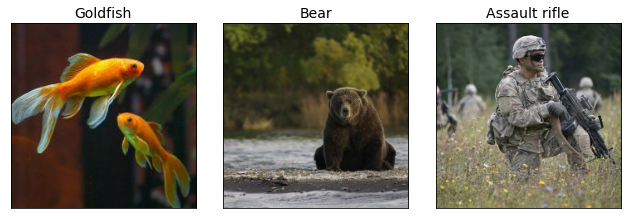

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img

# Load images
img1 = load_img('images/goldfish.jpg', target_size=(224, 224))
img2 = load_img('images/bear.jpg', target_size=(224, 224))
img3 = load_img('images/soldiers.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Image titles
image_titles = ['Goldfish', 'Bear', 'Assault rifle']

# Prepare datasets
X = preprocess_input(images)

# Render
subprot_args = {
    'nrows': 1,
    'ncols': 3,
    'figsize': (9, 3),
    'subplot_kw': {'xticks': [], 'yticks': []}
}
f, ax = plt.subplots(**subprot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

### Define necessary functions

At first, you need to define `loss` function that return target score. Here, it return the scores that corresponding Goldfish, Bear, Assault Rifle.

And then, the softmax activation function which is applied to model's last layer may obstruct generating shape attention images, so that you need to replace the function to a linear function using `model_modifier`.

In [4]:
# Define loss function. 1 is the imagenet index corresponding to Goldfish,
# 294 to Bear and 413 to Assault Rifle.
def loss(output):
    return (output[0][1], output[1][294], output[2][413])

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

## Vanilla Saliency

`Saliency` generate the saliency map that appears input regions that a change in the input value contribute the output value.

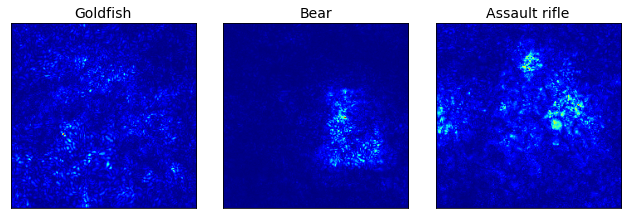

In [5]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object
saliency = Saliency(model, model_modifier, clone=False)

# Generate saliency map
saliency_map = saliency(loss, X)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subprot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.savefig('images/vanilla-saliency.png')
plt.show()

## SmoothGrad

As you can see avobe, Vanilla Saliency map is too noisy, so that let's remove noise in saliency map using SmoothGrad! SmoothGrad is a algorism that reduce noise including saliency map by adding noise to input image.

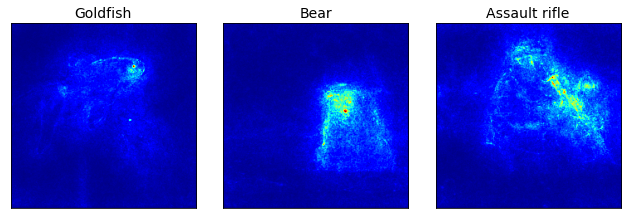

In [6]:
# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss, X, smooth_samples=20)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subprot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.savefig('images/smoothgrad.png')
plt.show()

## GradCAM

Saliency is one of useful way of visualizing attention that appears input regions that a change in the input value contribute the output value.
GradCAM is another way of visualizing attention over input. Instead of using gradients with respect to model outputs, it uses penultimate (pre Dense layer) Conv layer output.

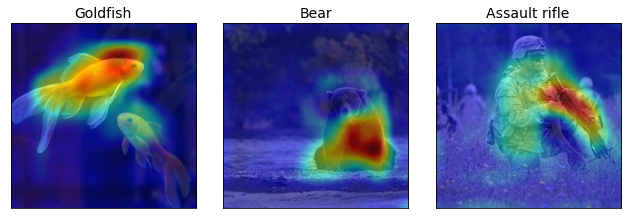

In [7]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

# Create Gradcam object
gradcam = Gradcam(model, model_modifier, clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss, X)
cam = normalize(cam)

f, ax = plt.subplots(**subprot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.savefig('images/gradcam.png')
plt.show()